<a href="https://www.analytiksinc.com">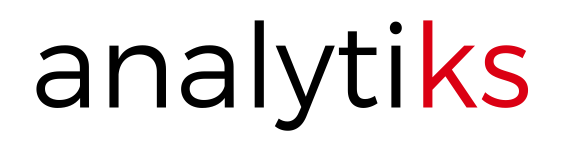</a>
<p style="text-align: right;"> © 2018. Analytiks Inc. </p>

# Time Series Analysis on Passenger Data

## Import Libraries

### Standard Libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

### Additional Libraries

In [2]:
from statsmodels.tsa.stattools import adfuller #Dickey-Fuller Test which can tells us if the time series is stationary or not
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import RandomForestRegressor

C:\Users\128006\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from sklearn.exceptions import DataConversionWarning

import warnings
warnings.filterwarnings("ignore", category=DataConversionWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

## Create Helper Functions (OPTIONAL)

In [4]:
#Create function for checking stationarity (Optional)

def ts_plot(timeseries): #puts time series in a plot, plots the mean, running mean and variance
    
    #Determine Rolling Statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    #Plot the data
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label= 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    
def ts_stats(timeseries): 
    #Check Summary Statistics
    ts_len = len(timeseries)/2
    X1, X2 = timeseries[:ts_len], timeseries[ts_len:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print 'Mean1: %f, Mean2: %f' % (mean1, mean2)
    print 'Var1: %f, Var2: %f' % (var1, var2)
    
    
def ts_dftest(timeseries):
    #Perform the Dickey Fuller Test:
    print 'Results of Dickey-Fuller Test'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

## Load and Explore the Dataset

In [5]:
data = pd.read_csv('AirPassengers.csv', index_col=0, parse_dates=True)

View the Dataset

In [6]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


data.info()

Check Info

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
#Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


Convert to Series type for easier manipulation

In [8]:
ts = data['#Passengers'] #time series is easier if you are working with one variable

In [9]:
type(ts)

pandas.core.series.Series

In [10]:
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

Check Start and End Date of the Series

In [11]:
print(ts.index.min(),ts.index.max())

(Timestamp('1949-01-01 00:00:00'), Timestamp('1960-12-01 00:00:00'))


## Check for Stationarity

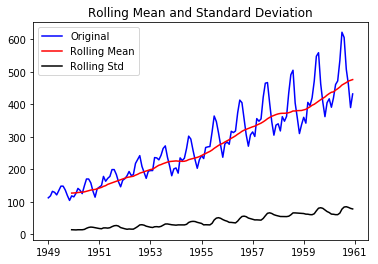

In [12]:
#Plot the Data
ts_plot(ts)

In [13]:
#Check Summary Statistics
ts_stats(ts)

Mean1: 182.902778, Mean2: 377.694444
Var1: 2275.694640, Var2: 7471.736307


In [14]:
#Perform Augmented Dickey-Fuller Test 
#always look for the p value and make sure it is less than .05 to ensure that the series is stationary
#test statistic should be less than the numbers in the critical value
ts_dftest(ts)

Results of Dickey-Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


**Based on above analysis, the time series is NOT stationary**

## Stationarize The Series

### Log Transformation

Get the log value

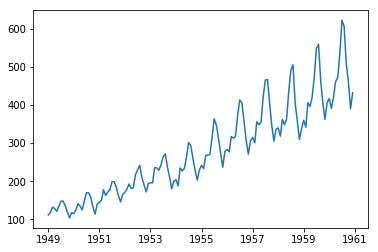

In [15]:
#Get the Log Transformation and Plot the TS
ts_log = np.log(ts)
plt.plot(ts)

In [16]:
#Check the summary statistics
ts_stats(ts_log)

Mean1: 5.175146, Mean2: 5.909206
Var1: 0.069338, Var2: 0.049958


In [17]:
# Perform Augmented Dicky-Fuller Test
ts_dftest(ts_log)

Results of Dickey-Fuller Test
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


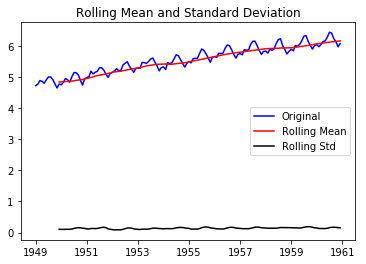

In [18]:
ts_plot(ts_log)

### Remove Trend using Smoothing (Rolling Mean)

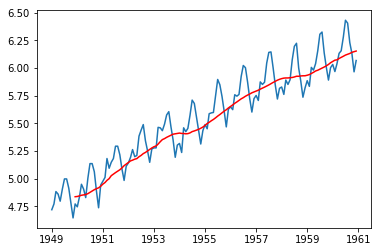

In [19]:
#Get Rolling Mean and plot it against Log-Transformed TS
moving_avg_ts = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg_ts, color='red')

In [20]:
#Subtract the Rolling Mean from the Log-Transformed TS
ts_log_ma_diff = ts_log - moving_avg_ts
ts_log_ma_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

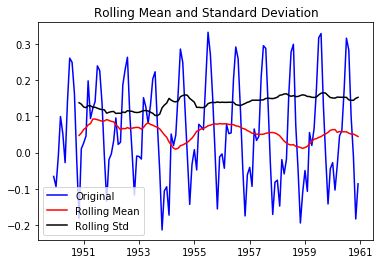

In [21]:
#Drop null values and Plot the Resulting Data
ts_log_ma_diff.dropna(inplace=True)
ts_plot(ts_log_ma_diff)

In [22]:
#Check Summary Statistics
ts_stats(ts_log_ma_diff)

Mean1: 0.056415, Mean2: 0.053356
Var1: 0.014322, Var2: 0.022356


In [23]:
# Perform Augmented Dicky-Fuller Test
ts_dftest(ts_log_ma_diff)

Results of Dickey-Fuller Test
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


**test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.**

### Apply Differencing (Usually perform this first!)

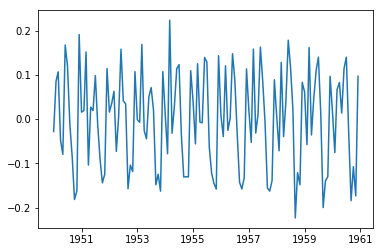

In [24]:
#Subtract from Previous Value (Lag of 1) and plot the resulting TS
ts_log_ma_diff_d = ts_log_ma_diff - ts_log_ma_diff.shift()
plt.plot(ts_log_ma_diff_d)

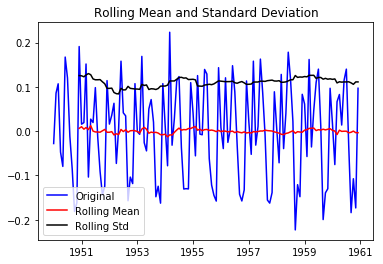

In [25]:
ts_plot(ts_log_ma_diff_d)

In [26]:
#Drop Null Values
ts_log_ma_diff_d.dropna(inplace=True)

In [27]:
# Perform Augmented Dicky-Fuller Test
ts_dftest(ts_log_ma_diff_d)

Results of Dickey-Fuller Test
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (5%)             -2.886363
Critical Value (1%)             -3.487022
Critical Value (10%)            -2.580009
dtype: float64


**test statistic is smaller than the 1% critical values and p-value is less than 0.05, resulting in a stationary series.**

## Plot ACF/PACF For Optimal Parameters

Figure(432x288)
Figure(432x288)


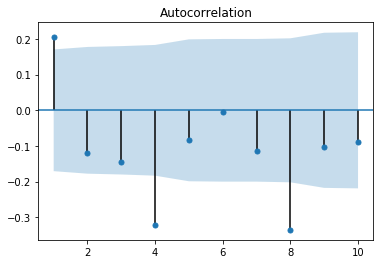

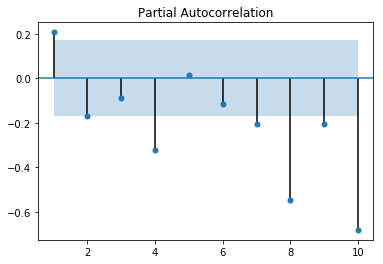

In [28]:
# alpha - the confidence intervals for the given level
# If alpha=.05, 95% confidence intervals are returned.

print(plot_acf(ts_log_ma_diff_d, lags=10, alpha=0.05,zero=False))
print(plot_pacf(ts_log_ma_diff_d, lags=10, alpha=0.05, zero=False)) 

* p value = 1
* q value = 1

## BUILD THE ARIMA MODEL

Text(0.5,1,'SSE: 1.4392')

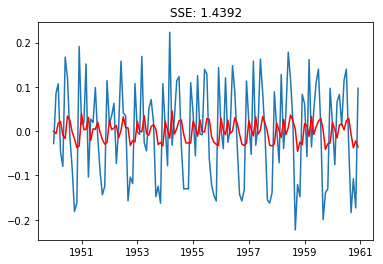

In [29]:
#AR Model
model = ARIMA(ts_log_ma_diff, order=(1,1,0), freq='MS') #order = p,d,q
results_AR = model.fit()
plt.plot(ts_log_ma_diff_d)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('SSE: %.4f'% sum((results_AR.fittedvalues-ts_log_ma_diff_d)**2))

Text(0.5,1,'SSE: 1.4155')

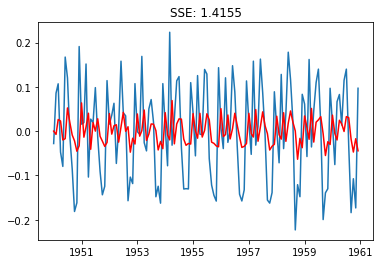

In [30]:
#MA Model
model = ARIMA(ts_log_ma_diff, order=(0,1,1), freq='MS')
results_MA = model.fit()
plt.plot(ts_log_ma_diff_d)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('SSE: %.4f'% sum((results_MA.fittedvalues-ts_log_ma_diff_d)**2))

Text(0.5,1,'SSE: 1.3043')

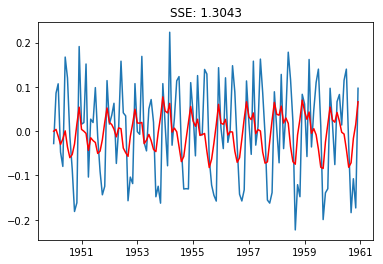

In [31]:
#ARIMA Model
model = ARIMA(ts_log_ma_diff, order=(1,1,1), freq='MS')
results_ARIMA = model.fit()
plt.plot(ts_log_ma_diff_d)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('SSE: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_ma_diff_d)**2))

#You don't want to overfit the model. You can determine if the model is a good model if its something that is closer to a line. 

## Transform Derived Values to Original

In [32]:
predictions_ARIMA_d = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_d.head()

Month
1950-01-01   -0.000193
1950-02-01    0.004009
1950-03-01   -0.011287
1950-04-01   -0.029992
1950-05-01   -0.017537
dtype: float64

In [33]:
#Get cumulative sum of differenced series
predictions_ARIMA_d_cumsum = predictions_ARIMA_d.cumsum()
predictions_ARIMA_d_cumsum.head()

Month
1950-01-01   -0.000193
1950-02-01    0.003816
1950-03-01   -0.007471
1950-04-01   -0.037463
1950-05-01   -0.055000
dtype: float64

In [34]:
#Get Base Log Value
base_log = pd.Series(ts_log_ma_diff.iloc[0], index=ts_log_ma_diff.index) 
base_log.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.065494
1950-02-01   -0.065494
1950-03-01   -0.065494
1950-04-01   -0.065494
dtype: float64

In [35]:
#Add to cumsum of differenced series
predictions_ARIMA_log = base_log.add(predictions_ARIMA_d_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.065687
1950-02-01   -0.061678
1950-03-01   -0.072964
1950-04-01   -0.102957
dtype: float64

In [36]:
#Add Back Moving Average
predictions_ARIMA_log_add_ma = (predictions_ARIMA_log + moving_avg_ts).dropna()
predictions_ARIMA_log_add_ma.head() 

Month
1949-12-01    4.770685
1950-01-01    4.772694
1950-02-01    4.782170
1950-03-01    4.776380
1950-04-01    4.750176
dtype: float64

In [37]:
#Take exponent to convert to original scale
predictions_ARIMA = np.exp(predictions_ARIMA_log_add_ma)
predictions_ARIMA.head()

Month
1949-12-01    118.000000
1950-01-01    118.237363
1950-02-01    119.363085
1950-03-01    118.673951
1950-04-01    115.604644
dtype: float64

Text(0.5,1,'RMSE: 127.7743')

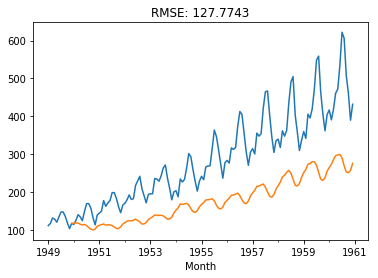

In [38]:
#Plot the results
difference = (predictions_ARIMA-ts).dropna()
ts.plot()
predictions_ARIMA.plot()
plt.title('RMSE: %.4f'% np.sqrt(sum((difference)**2)/len(ts)))

## SUPERVISED LEARNING EXAMPLE: RANDOM FOREST REGRESSOR - You can improve the model by optimizing the hyperparameters

In [39]:
rf = RandomForestRegressor()

In [40]:
#Transform the data into a supervised learning problem, we will be using ts_log_ma_diff_d as the dataset. 
ts_log_ma_diff_d.head()

Month
1950-01-01   -0.027955
1950-02-01    0.085883
1950-03-01    0.106981
1950-04-01   -0.047274
1950-05-01   -0.079671
Name: #Passengers, dtype: float64

In [41]:
data_supervised = pd.DataFrame(index=ts_log_ma_diff_d.index)
data_supervised['X'] = ts_log_ma_diff_d.shift(1) #Shift of Lag 1
data_supervised['y'] = ts_log_ma_diff_d

In [42]:
data_supervised.dropna(inplace=True)

In [43]:
data_supervised.head()

,X,y
Month,,
1950-02-01,-0.027955,0.085883
1950-03-01,0.085883,0.106981
1950-04-01,0.106981,-0.047274
1950-05-01,-0.047274,-0.079671
1950-06-01,-0.079671,0.167410


In [44]:
train = data_supervised[:len(data_supervised)/2]
test = data_supervised[len(data_supervised)/2:]

#be careful in splitting to train and test

In [45]:
X_train = train.X.values.reshape(-1,1)
y_train = train.y.values.reshape(-1,)
X_test = test.X.values.reshape(-1, 1)
y_test = test.y.values.reshape(-1,)

In [46]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [47]:
rf_results = rf.predict(X_test)

Text(0.5,1,'SSE: 1.0809')

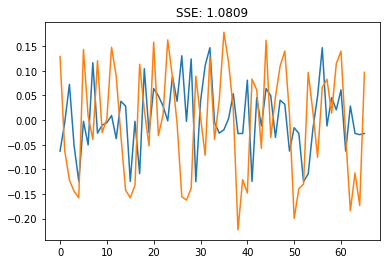

In [48]:
plt.plot(rf_results)
plt.plot(y_test)
plt.title('SSE: %.4f'% sum((rf_results-y_test)**2))

In [49]:
#SCALE BACK TO ORIGINAL VALUES

#Get cumulative sum of differenced series
rf_results_cumsum = rf_results.cumsum()
#Add to cumsum of differenced series
rf_results_log = base_log[test.index].add(rf_results_cumsum, fill_value=0)
#Add back moving average
rf_results_add_ma = (rf_results_log + moving_avg_ts).dropna()
rf_results_prediction = np.exp(rf_results_add_ma)

In [50]:
rf_results_final = pd.Series(rf_results_prediction, index=test.index)

Text(0.5,1,'RMSE: 82.0918')

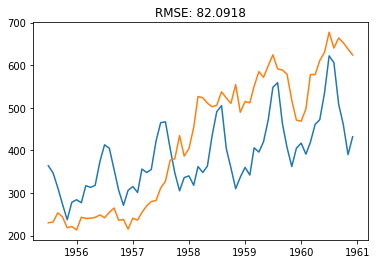

In [51]:
#Plot the results
plt.plot(ts[test.index])
plt.plot(rf_results_final)
plt.title('RMSE: %.4f'% np.sqrt(sum((rf_results_final-ts[test.index])**2)/len(ts)))

## Polynomial Linear Regression

In [52]:
#Polynomial Linear Regression
data_supervised['X2'] = data_supervised.X ** 2
data_supervised['X3'] = data_supervised.X ** 3
data_supervised['y'] = ts_log_ma_diff_d

In [53]:
features = data_supervised.drop(['y'], axis=1)
target = data_supervised['y']

In [54]:
X_train = features[:len(features)/2]
X_test = features[len(features)/2:]
y_train = target[:len(target)/2].values.reshape(-1,1)
y_test = target[len(target)/2:].values.reshape(-1,1)

In [55]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()

In [56]:
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [57]:
lin_predict = regr.predict(X_test)

Text(0.5,1,'SSE: 0.7649')

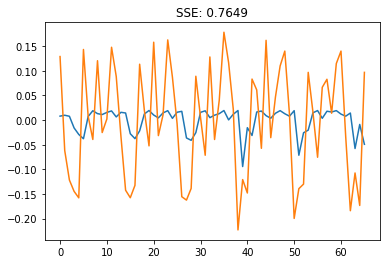

In [58]:
plt.plot(lin_predict)
plt.plot(y_test)
plt.title('SSE: %.4f'% sum((lin_predict-y_test)**2))


In [59]:
#SCALE BACK TO ORIGINAL VALUES

#Get cumulative sum of differenced series
lin_results_cumsum = lin_predict.cumsum()
#Add to cumsum of differenced series
lin_results_log = base_log[test.index].add(lin_results_cumsum, fill_value=0)
#Add back moving average
lin_results_add_ma = (lin_results_log + moving_avg_ts).dropna()
lin_results_prediction = np.exp(lin_results_add_ma)

Text(0.5,1,'RMSE: 43.2086')

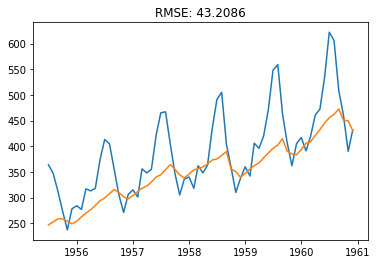

In [60]:
plt.plot(ts[X_test.index])
plt.plot(lin_results_prediction)
plt.title('RMSE: %.4f'% np.sqrt(sum((lin_results_prediction-ts[X_test.index])**2)/len(ts)))

## SCALING BACK TO ORIGINAL SCALE SAMPLE

In [61]:
#Original Log Values (TARGET)
ts_log[11:].head()

Month
1949-12-01    4.770685
1950-01-01    4.744932
1950-02-01    4.836282
1950-03-01    4.948760
1950-04-01    4.905275
Name: #Passengers, dtype: float64

In [62]:
#Log Values with Moving Average Trend Removed
ts_log_ma_diff.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: #Passengers, dtype: float64

In [63]:
#Log Values Differenced with Lag(1)
ts_log_ma_diff_d.head()

Month
1950-01-01   -0.027955
1950-02-01    0.085883
1950-03-01    0.106981
1950-04-01   -0.047274
1950-05-01   -0.079671
Name: #Passengers, dtype: float64

In [64]:
#Get cumulative sum of differenced series
ts_log_ma_diff_d_cumsum = ts_log_ma_diff_d.cumsum()
ts_log_ma_diff_d_cumsum.head()

Month
1950-01-01   -0.027955
1950-02-01    0.057928
1950-03-01    0.164910
1950-04-01    0.117636
1950-05-01    0.037965
Name: #Passengers, dtype: float64

In [65]:
#Get Base Log Value
base_log = pd.Series(ts_log_ma_diff.iloc[0], index=ts_log_ma_diff.index) 

#Add to cumsum of differenced series
base_log_cumsum = base_log.add(ts_log_ma_diff_d_cumsum, fill_value=0)
base_log.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.065494
1950-02-01   -0.065494
1950-03-01   -0.065494
1950-04-01   -0.065494
dtype: float64

In [66]:
base_log_cumsum.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
dtype: float64

In [67]:
#Add Back Moving Average
ts_log_ma_add = (base_log_cumsum + moving_avg_ts).dropna()
ts_log_ma_add.head() # Should be equal to ts_log

Month
1949-12-01    4.770685
1950-01-01    4.744932
1950-02-01    4.836282
1950-03-01    4.948760
1950-04-01    4.905275
dtype: float64

In [68]:
#Take exponent to convert to original scale
ts_original = np.exp(ts_log_ma_add)
ts_original.head()

Month
1949-12-01    118.0
1950-01-01    115.0
1950-02-01    126.0
1950-03-01    141.0
1950-04-01    135.0
dtype: float64

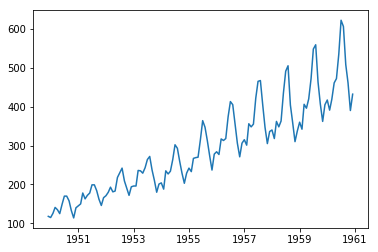

In [69]:
plt.plot(ts_original)
